In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.data import DataLoader
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from graph_transformer import GT
from utils import pre_process, pre_process_with_summary, concat_pre_process_with_summary, inf_sum_pre_process_with_summary, fin_sum_pre_process_with_summary, get_n_params, get_optimizer
import datetime
from tqdm import tqdm
from tensorboardX import SummaryWriter
import pytz

In [2]:
parser = argparse.ArgumentParser(description='PyTorch implementation of relative positional encodings and relation-aware self-attention for graph Transformers')
args = parser.parse_args("")

args.dataset = 'ogbg-molhiv'
args.n_classes = 1
args.lr = 3e-4
args.n_hid = 512
args.n_heads = 8
args.n_layer = 4
args.dropout = 0.3
args.num_epochs = 50
args.k_hop_neighbors = 3
args.k_hop = True
args.weight_decay = 1e-2
# args.bsz      = 512
args.bsz      = 448
# args.strategies = ['ea', 'rw_concat', 'sym_concat']
args.strategies = ['ea', 'rw_concat']
args.summary_node = True
args.hier_levels = 3
args.lap_k = None
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.metric = 'rocauc'
print("device:", args.device)

device: cuda


In [3]:
print("Loading data...")
print("dataset: {} ".format(args.dataset))
tz = pytz.timezone('US/Pacific')
time_now = datetime.datetime.now(tz).strftime('%m-%d_%H:%M:%S')

if args.summary_node:
    pre_transform = lambda d : concat_pre_process_with_summary(d, args)
    root_path= f'dataset/{args.dataset}/concat_with_summary_{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/concat_with_summary_{args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')

else:
    pre_transform = lambda d : pre_process(d, args)
    root_path= f'dataset/{args.dataset}/{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')
    
    
dataset = PygGraphPropPredDataset(name=args.dataset, pre_transform=pre_transform, root = root_path)
evaluator = Evaluator(name=args.dataset)
split_idx = dataset.get_idx_split()
edge_dim_dict = {'ea': None, \
                 'disc': {
#                      'sd': (dataset.data.sd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'cn': (dataset.data.cn_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'hsd': (dataset.data.hsd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                    },
                 'cont': {
#                      **{('sym_' + str(k)): args.n_hid for k in range(1, args.k_hop_neighbors + 1)},
                     **{('rw_' + str(k)): args.n_hid for k in range(1, args.k_hop_neighbors + 1)}
#                      'rw': args.n_hid
                 }
                }
model = GT(args.n_hid, args.n_classes, args.n_heads, args.n_layer, edge_dim_dict, args.dropout, args.summary_node, args.lap_k).to(args.device)

Loading data...
dataset: ogbg-molhiv 


In [4]:
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

In [5]:
print('Model #Params: %d' % get_n_params(model))

criterion = torch.nn.BCEWithLogitsLoss(reduction = "mean")

optimizer = get_optimizer(model, weight_decay = args.weight_decay, learning_rate = args.lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 500, eta_min=1e-6)
scheduler.step(-500)

Model #Params: 10338817


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

In [6]:
import seaborn as sb
def mat_visualize(node_size, edge_index, edge_attr):
    mat = np.zeros((node_size, node_size))
    for e, v in zip(edge_index, edge_attr):
        mat[e[0]][e[1]] = v
    sb.heatmap(mat)

/opt/conda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def turn_prob(inp):
    prob = torch.sigmoid(inp)
    prob = torch.cat([prob, 1-prob], dim=1)
    return prob

In [8]:
train_mask = torch.zeros(len(dataset), dtype=bool)
valid_mask = torch.zeros(len(dataset), dtype=bool)
test_mask = torch.zeros(len(dataset), dtype=bool)

train_mask[split_idx["train"]] = True
valid_mask[split_idx["valid"]] = True
test_mask[split_idx["test"]] = True
def entropy_loss(pred, label):
    return torch.mean(torch.sum(-label * pred, dim=1))

In [9]:
stats = []
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    train_adv  = []
    y_true = []
    y_scores = []
    all_idx = torch.randperm(len(dataset))
    for batch_idx in tqdm(range(len(all_idx) // args.bsz)):
        batch = all_idx[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        train_msk = train_mask[batch]    
        data = Batch.from_data_list(dataset[batch])
        data.to(args.device)
        
        strats = {'ea': data.edge_attr, \
#                  **{('sym_' + str(k)): data['sym_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}, \
                 **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
#         strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
        out, _ = model(data.x, data.batch, data.edge_index, strats)
        with torch.no_grad():
            strats = {'ea': data.edge_attr, \
#                   **{('sym_' + str(k)): data['sym_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}, \
                 **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
#             strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
            adv_out, _ = model(data.x, data.batch, data.edge_index, strats)
        
        loss = criterion(out[train_msk], data.y[train_msk].float())
        # loss = criterion(out, data.y.float())
        adv_loss = entropy_loss(turn_prob(out[train_msk]).log(), turn_prob(adv_out[train_msk]))
        (loss + 0.5 * adv_loss).backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        train_loss += [loss.item()]
        train_adv  += [adv_loss.item()]
        
        y_true += [data.y]
        y_scores += [out]

    input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
    train_metric = evaluator.eval(input_dict)[args.metric]
    

    model.eval()
    with torch.no_grad():
        valid_loss = []
        y_true = []
        y_scores = []
        for num_iters, data in enumerate(tqdm(valid_loader)):
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
#                   **{('sym_' + str(k)): data['sym_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}, \
                 **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
 #            strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
            out, _ = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            valid_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        valid_metric = evaluator.eval(input_dict)[args.metric]
        
        test_loss = []
        y_true = []
        y_scores = []
        for data in test_loader:
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
#                   **{('sym_' + str(k)): data['sym_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}, \
                 **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
#             strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
            out, _ = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            test_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        test_metric = evaluator.eval(input_dict)[args.metric]

    print('Epoch %d: LR: %.5f, Train loss: %.3f Train %s: %.3f Train Adv: %.3f Valid loss: %.3f  Valid %s: %.3f \
        Test loss: %.3f  Test %s: %.3f' \
          % (epoch + 1, optimizer.param_groups[0]['lr'], np.average(train_loss), args.metric, train_metric, \
             np.average(train_adv), np.average(valid_loss), args.metric, valid_metric, \
             np.average(test_loss), args.metric, test_metric))
    stats += [[epoch, np.average(train_loss), train_metric, np.average(valid_loss), valid_metric, np.average(test_loss), test_metric]]

  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1: LR: 0.00002, Train loss: 0.267 Train rocauc: 0.512 Train Adv: 0.361 Valid loss: 0.093  Valid rocauc: 0.402         Test loss: 0.156  Test rocauc: 0.392


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2: LR: 0.00009, Train loss: 0.162 Train rocauc: 0.495 Train Adv: 0.157 Valid loss: 0.092  Valid rocauc: 0.620         Test loss: 0.156  Test rocauc: 0.620


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3: LR: 0.00017, Train loss: 0.161 Train rocauc: 0.523 Train Adv: 0.161 Valid loss: 0.090  Valid rocauc: 0.647         Test loss: 0.149  Test rocauc: 0.653


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4: LR: 0.00025, Train loss: 0.159 Train rocauc: 0.571 Train Adv: 0.156 Valid loss: 0.085  Valid rocauc: 0.729         Test loss: 0.136  Test rocauc: 0.685


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5: LR: 0.00029, Train loss: 0.151 Train rocauc: 0.674 Train Adv: 0.157 Valid loss: 0.089  Valid rocauc: 0.697         Test loss: 0.132  Test rocauc: 0.696


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6: LR: 0.00029, Train loss: 0.145 Train rocauc: 0.703 Train Adv: 0.149 Valid loss: 0.085  Valid rocauc: 0.719         Test loss: 0.128  Test rocauc: 0.717


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7: LR: 0.00025, Train loss: 0.138 Train rocauc: 0.742 Train Adv: 0.144 Valid loss: 0.077  Valid rocauc: 0.779         Test loss: 0.134  Test rocauc: 0.694


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8: LR: 0.00017, Train loss: 0.136 Train rocauc: 0.741 Train Adv: 0.143 Valid loss: 0.083  Valid rocauc: 0.763         Test loss: 0.126  Test rocauc: 0.713


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9: LR: 0.00009, Train loss: 0.134 Train rocauc: 0.754 Train Adv: 0.138 Valid loss: 0.086  Valid rocauc: 0.785         Test loss: 0.130  Test rocauc: 0.733


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10: LR: 0.00002, Train loss: 0.131 Train rocauc: 0.767 Train Adv: 0.138 Valid loss: 0.080  Valid rocauc: 0.788         Test loss: 0.124  Test rocauc: 0.739


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 11: LR: 0.00000, Train loss: 0.129 Train rocauc: 0.777 Train Adv: 0.132 Valid loss: 0.078  Valid rocauc: 0.786         Test loss: 0.123  Test rocauc: 0.738


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 12: LR: 0.00003, Train loss: 0.128 Train rocauc: 0.776 Train Adv: 0.137 Valid loss: 0.077  Valid rocauc: 0.785         Test loss: 0.123  Test rocauc: 0.738


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 13: LR: 0.00009, Train loss: 0.129 Train rocauc: 0.778 Train Adv: 0.137 Valid loss: 0.078  Valid rocauc: 0.784         Test loss: 0.121  Test rocauc: 0.744


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 14: LR: 0.00017, Train loss: 0.129 Train rocauc: 0.774 Train Adv: 0.138 Valid loss: 0.073  Valid rocauc: 0.790         Test loss: 0.122  Test rocauc: 0.746


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 15: LR: 0.00025, Train loss: 0.129 Train rocauc: 0.775 Train Adv: 0.138 Valid loss: 0.080  Valid rocauc: 0.789         Test loss: 0.127  Test rocauc: 0.726


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 16: LR: 0.00029, Train loss: 0.130 Train rocauc: 0.767 Train Adv: 0.137 Valid loss: 0.073  Valid rocauc: 0.789         Test loss: 0.120  Test rocauc: 0.762


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 17: LR: 0.00029, Train loss: 0.130 Train rocauc: 0.764 Train Adv: 0.137 Valid loss: 0.078  Valid rocauc: 0.792         Test loss: 0.123  Test rocauc: 0.752


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 18: LR: 0.00025, Train loss: 0.129 Train rocauc: 0.769 Train Adv: 0.137 Valid loss: 0.077  Valid rocauc: 0.789         Test loss: 0.127  Test rocauc: 0.732


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 19: LR: 0.00017, Train loss: 0.126 Train rocauc: 0.777 Train Adv: 0.135 Valid loss: 0.075  Valid rocauc: 0.797         Test loss: 0.120  Test rocauc: 0.747


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 20: LR: 0.00009, Train loss: 0.123 Train rocauc: 0.794 Train Adv: 0.132 Valid loss: 0.081  Valid rocauc: 0.781         Test loss: 0.123  Test rocauc: 0.740


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 21: LR: 0.00002, Train loss: 0.120 Train rocauc: 0.800 Train Adv: 0.129 Valid loss: 0.076  Valid rocauc: 0.792         Test loss: 0.121  Test rocauc: 0.745


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 22: LR: 0.00000, Train loss: 0.119 Train rocauc: 0.803 Train Adv: 0.129 Valid loss: 0.076  Valid rocauc: 0.791         Test loss: 0.122  Test rocauc: 0.746


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 23: LR: 0.00003, Train loss: 0.118 Train rocauc: 0.806 Train Adv: 0.128 Valid loss: 0.075  Valid rocauc: 0.792         Test loss: 0.121  Test rocauc: 0.747


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 24: LR: 0.00009, Train loss: 0.119 Train rocauc: 0.803 Train Adv: 0.129 Valid loss: 0.075  Valid rocauc: 0.809         Test loss: 0.122  Test rocauc: 0.749


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 25: LR: 0.00017, Train loss: 0.119 Train rocauc: 0.796 Train Adv: 0.130 Valid loss: 0.079  Valid rocauc: 0.794         Test loss: 0.122  Test rocauc: 0.763


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 26: LR: 0.00025, Train loss: 0.123 Train rocauc: 0.794 Train Adv: 0.134 Valid loss: 0.074  Valid rocauc: 0.774         Test loss: 0.124  Test rocauc: 0.734


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 27: LR: 0.00029, Train loss: 0.124 Train rocauc: 0.786 Train Adv: 0.134 Valid loss: 0.073  Valid rocauc: 0.781         Test loss: 0.121  Test rocauc: 0.750


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 28: LR: 0.00029, Train loss: 0.125 Train rocauc: 0.777 Train Adv: 0.135 Valid loss: 0.076  Valid rocauc: 0.778         Test loss: 0.120  Test rocauc: 0.754


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 29: LR: 0.00025, Train loss: 0.125 Train rocauc: 0.783 Train Adv: 0.138 Valid loss: 0.083  Valid rocauc: 0.749         Test loss: 0.125  Test rocauc: 0.742


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 30: LR: 0.00017, Train loss: 0.121 Train rocauc: 0.792 Train Adv: 0.134 Valid loss: 0.076  Valid rocauc: 0.763         Test loss: 0.116  Test rocauc: 0.768


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 31: LR: 0.00009, Train loss: 0.119 Train rocauc: 0.805 Train Adv: 0.127 Valid loss: 0.075  Valid rocauc: 0.781         Test loss: 0.118  Test rocauc: 0.752


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 32: LR: 0.00002, Train loss: 0.115 Train rocauc: 0.812 Train Adv: 0.129 Valid loss: 0.076  Valid rocauc: 0.784         Test loss: 0.121  Test rocauc: 0.753


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 33: LR: 0.00000, Train loss: 0.114 Train rocauc: 0.821 Train Adv: 0.123 Valid loss: 0.076  Valid rocauc: 0.787         Test loss: 0.121  Test rocauc: 0.750


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 34: LR: 0.00003, Train loss: 0.113 Train rocauc: 0.821 Train Adv: 0.124 Valid loss: 0.077  Valid rocauc: 0.786         Test loss: 0.121  Test rocauc: 0.749


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 35: LR: 0.00009, Train loss: 0.114 Train rocauc: 0.818 Train Adv: 0.126 Valid loss: 0.071  Valid rocauc: 0.800         Test loss: 0.120  Test rocauc: 0.748


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 36: LR: 0.00017, Train loss: 0.114 Train rocauc: 0.818 Train Adv: 0.128 Valid loss: 0.072  Valid rocauc: 0.798         Test loss: 0.120  Test rocauc: 0.750


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 37: LR: 0.00025, Train loss: 0.117 Train rocauc: 0.809 Train Adv: 0.130 Valid loss: 0.071  Valid rocauc: 0.831         Test loss: 0.121  Test rocauc: 0.769


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 38: LR: 0.00029, Train loss: 0.120 Train rocauc: 0.795 Train Adv: 0.129 Valid loss: 0.077  Valid rocauc: 0.806         Test loss: 0.128  Test rocauc: 0.731


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 39: LR: 0.00029, Train loss: 0.121 Train rocauc: 0.789 Train Adv: 0.134 Valid loss: 0.076  Valid rocauc: 0.779         Test loss: 0.125  Test rocauc: 0.745


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 40: LR: 0.00025, Train loss: 0.122 Train rocauc: 0.797 Train Adv: 0.136 Valid loss: 0.074  Valid rocauc: 0.797         Test loss: 0.123  Test rocauc: 0.746


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 41: LR: 0.00017, Train loss: 0.119 Train rocauc: 0.808 Train Adv: 0.131 Valid loss: 0.080  Valid rocauc: 0.807         Test loss: 0.126  Test rocauc: 0.738


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 42: LR: 0.00009, Train loss: 0.115 Train rocauc: 0.819 Train Adv: 0.128 Valid loss: 0.076  Valid rocauc: 0.809         Test loss: 0.125  Test rocauc: 0.738


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 43: LR: 0.00002, Train loss: 0.112 Train rocauc: 0.824 Train Adv: 0.125 Valid loss: 0.074  Valid rocauc: 0.814         Test loss: 0.122  Test rocauc: 0.746


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 44: LR: 0.00000, Train loss: 0.109 Train rocauc: 0.834 Train Adv: 0.122 Valid loss: 0.076  Valid rocauc: 0.811         Test loss: 0.124  Test rocauc: 0.748


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 45: LR: 0.00003, Train loss: 0.109 Train rocauc: 0.833 Train Adv: 0.120 Valid loss: 0.075  Valid rocauc: 0.812         Test loss: 0.123  Test rocauc: 0.750


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 46: LR: 0.00009, Train loss: 0.110 Train rocauc: 0.826 Train Adv: 0.124 Valid loss: 0.077  Valid rocauc: 0.801         Test loss: 0.122  Test rocauc: 0.751


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 47: LR: 0.00018, Train loss: 0.112 Train rocauc: 0.823 Train Adv: 0.123 Valid loss: 0.081  Valid rocauc: 0.777         Test loss: 0.124  Test rocauc: 0.745


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 48: LR: 0.00025, Train loss: 0.114 Train rocauc: 0.818 Train Adv: 0.126 Valid loss: 0.079  Valid rocauc: 0.796         Test loss: 0.132  Test rocauc: 0.752


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 49: LR: 0.00030, Train loss: 0.117 Train rocauc: 0.809 Train Adv: 0.130 Valid loss: 0.080  Valid rocauc: 0.797         Test loss: 0.124  Test rocauc: 0.748


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch 50: LR: 0.00029, Train loss: 0.121 Train rocauc: 0.791 Train Adv: 0.132 Valid loss: 0.073  Valid rocauc: 0.788         Test loss: 0.122  Test rocauc: 0.742


[36.          0.11741311  0.80889089  0.07101434  0.8313982   0.12133697
  0.76936017]


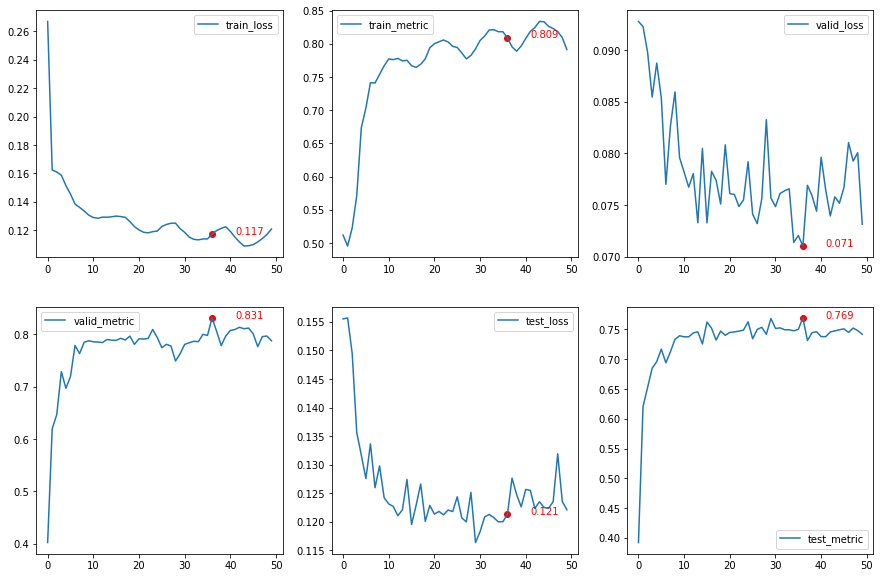

In [10]:
import matplotlib.pyplot as plt
labels = ['epoch', 'train_loss', 'train_metric', 'valid_loss', 'valid_metric', 'test_loss', 'test_metric']
fig = plt.figure(figsize=(15, 10))
stats_np = np.array(stats)
best_valid = stats_np[stats_np[:50, 4].argmax()]
print(best_valid)
for i in range(1, stats_np.shape[-1]):
    ax = fig.add_subplot(2, 3, i)
    ax.plot(stats_np[:, i], label=labels[i])
    ax.scatter(x=best_valid[0], y=best_valid[i], color='red')
    ax.annotate(best_valid[i].round(3), xy=(best_valid[0]+5, best_valid[i]), color='red')
    ax.legend()
